In [1]:
#############################################
# FraudDiffuse Model for Sparkov Dataset
# Following the paper EXACTLY:
# 1. Data is preprocessed using Data_Preprocessing.ipynb,
#    so numeric features are log-transformed & standardized,
#    and categorical features are factorized.
# 2. Preprocessed artifacts (standard_scaler, cat_vocab, cat_mapping)
#    are saved in Data/processed – we load them here for consistency.
# 3. The diffusion model is trained on fraud samples only.
# 4. The model uses an adaptive non-fraud numeric prior for a probability loss,
#    and categorical features are handled via embedding layers.
#############################################

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#############################################
# Step 1: Load Preprocessed Data & Artifacts
#############################################
X_train_df = pd.read_csv("Data/processed/X_train.csv")
y_train_df = pd.read_csv("Data/processed/y_train.csv")

# Load saved StandardScaler (for numeric features)
scaler = joblib.load("Data/processed/standard_scaler.pkl")
# Load the categorical vocabulary dictionary and mapping
cat_vocab = joblib.load("Data/processed/cat_vocab.pkl")
cat_mapping = joblib.load("Data/processed/cat_mapping.pkl")
print("Loaded transformation artifacts from Data/processed.")

# Define feature lists exactly as in your preprocessing:
# (Adjust these lists to match your Data_Preprocessing.ipynb)
num_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 
                'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
cat_features = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']

# Convert y_train to Series (assuming the first column is the target)
y_train = y_train_df.iloc[:, 0]

# Create boolean masks for fraud (target==1) and non-fraud (target==0)
fraud_mask = (y_train == 1)
nonfraud_mask = (y_train == 0)

# Split X_train_df into numeric and categorical parts:
# (Assuming numerical features are already normalized and saved accordingly,
#  and categorical features are integer codes)
X_train_num = X_train_df[num_features].loc[fraud_mask].values
X_train_cat = X_train_df[cat_features].loc[fraud_mask].values

# For computing the adaptive non-fraud prior (probability-based loss),
# load non-fraud numeric features:
X_nonfraud_num = X_train_df[num_features].loc[nonfraud_mask].values

Loaded transformation artifacts from Data/processed.


In [4]:
cat_vocab

{'merchant': 693,
 'category': 14,
 'gender': 2,
 'street': 999,
 'city': 906,
 'state': 51,
 'zip': 985,
 'job': 497}

In [5]:
cat_mapping

{'merchant': {'fraud_Rippin, Kub and Mann': 0,
  'fraud_Heller, Gutmann and Zieme': 1,
  'fraud_Lind-Buckridge': 2,
  'fraud_Kutch, Hermiston and Farrell': 3,
  'fraud_Keeling-Crist': 4,
  'fraud_Stroman, Hudson and Erdman': 5,
  'fraud_Rowe-Vandervort': 6,
  'fraud_Corwin-Collins': 7,
  'fraud_Herzog Ltd': 8,
  'fraud_Schoen, Kuphal and Nitzsche': 9,
  'fraud_Rutherford-Mertz': 10,
  'fraud_Kerluke-Abshire': 11,
  'fraud_Lockman Ltd': 12,
  'fraud_Kiehn Inc': 13,
  'fraud_Beier-Hyatt': 14,
  'fraud_Schmidt and Sons': 15,
  'fraud_Lebsack and Sons': 16,
  'fraud_Mayert Group': 17,
  'fraud_Konopelski, Schneider and Hartmann': 18,
  'fraud_Schultz, Simonis and Little': 19,
  'fraud_Bauch-Raynor': 20,
  'fraud_Harris Inc': 21,
  'fraud_Kling-Grant': 22,
  'fraud_Pacocha-Bauch': 23,
  'fraud_Lesch Ltd': 24,
  'fraud_Kunde-Sanford': 25,
  "fraud_Deckow-O'Conner": 26,
  'fraud_Bruen-Yost': 27,
  'fraud_Kunze Inc': 28,
  'fraud_Nitzsche, Kessler and Wolff': 29,
  'fraud_Kihn, Abernathy and D

In [6]:
#############################################
# Step 2: Create a Custom Dataset for Fraud Samples
#############################################
class SparkovFraudDataset(Dataset):
    def __init__(self, num_data, cat_data):
        # Convert numeric data to float tensor
        self.num_data = torch.tensor(num_data, dtype=torch.float32)
        # Keep categorical data as long tensor (integer codes)
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)
        
    def __len__(self):
        return self.num_data.shape[0]
    
    def __getitem__(self, idx):
        return self.num_data[idx], self.cat_data[idx]

# Create dataset for fraud samples
fraud_dataset = SparkovFraudDataset(X_train_num, X_train_cat)

In [8]:
#############################################
# Step 3: Set Device
#############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [9]:
#############################################
# Step 4: Diffusion Hyperparameters and Schedule
#############################################
T_train = 800  # diffusion steps for training
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T_train).to(device)  # noise variance schedule
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0)    # cumulative product for closed-form diffusion

# Loss weightings as in the paper:
w1 = 0.2  # probability-based loss weight (L_prior)
w2 = 0.6  # triplet loss weight

In [11]:
#############################################
# Step 5: Define the Combined Diffusion Model
# (Incorporates embedding layers for categorical features + MLP for noise prediction)
#############################################
class CombinedNoisePredictor(nn.Module):
    """
    This model exactly follows the paper’s architecture:
    - Numeric (normalized continuous) features are combined with
      embeddings from categorical features.
    - We append a normalized timestep and pass the combined vector
      through an MLP (with LeakyReLU activations) to predict the noise.
      
    This allows us to operate in a continuous space while handling
    categorical variables using learned dense embeddings.
    """
    def __init__(self, num_input_dim, cat_vocab_sizes, cat_embed_dim=2, hidden_dim=256):
        """
        num_input_dim: Dimension of numeric features (e.g., 11)
        cat_vocab_sizes: Dictionary with key = categorical feature name,
                         value = vocabulary size (obtained via the saved cat_vocab)
        cat_embed_dim: The embedding dimension for each categorical feature.
        hidden_dim: Hidden dimension for the MLP.
        """
        super(CombinedNoisePredictor, self).__init__()
        
        # Create an embedding layer for each categorical feature.
        self.embeddings = nn.ModuleDict()
        for col, vocab in cat_vocab_sizes.items():
            # Each embedding layer maps integer codes (0 to vocab_size-1) to a vector
            self.embeddings[col] = nn.Embedding(vocab, cat_embed_dim)
        
        # Total dimension from categorical embeddings:
        cat_total_dim = len(cat_vocab_sizes) * cat_embed_dim
        
        # Combined input = numeric features + categorical embeddings.
        combined_input_dim = num_input_dim + cat_total_dim
        
        # We add +1 to the input dimension to include the normalized timestep.
        self.fc1 = nn.Linear(combined_input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, combined_input_dim)
        self.activation = nn.LeakyReLU()
        
    def forward(self, x_num, x_cat, t):
        # Process each categorical feature through its embedding.
        embeds = []
        # The order of features in x_cat must match the order of keys in self.embeddings.
        for i, col in enumerate(self.embeddings):
            emb = self.embeddings[col](x_cat[:, i])
            embeds.append(emb)
        # Concatenate all categorical embeddings into one continuous vector.
        x_cat_emb = torch.cat(embeds, dim=1)
        # Concatenate numeric features and categorical embeddings.
        x = torch.cat([x_num, x_cat_emb], dim=1)
        # Append normalized timestep (t / T_train)
        t_norm = t.unsqueeze(1).float() / T_train
        x_input = torch.cat([x, t_norm], dim=1)
        h = self.activation(self.fc1(x_input))
        h = self.activation(self.fc2(h))
        out = self.fc3(h)
        return out

# Determine vocabulary sizes using the loaded cat_vocab.
# cat_vocab already has integer counts, we just assign them directly
cat_vocab_sizes = {}
for col in cat_features:
    cat_vocab_sizes[col] = cat_vocab[col]
print("Categorical vocabulary sizes:", cat_vocab_sizes)

# Create the model.
num_input_dim = len(num_features)  # E.g., 11
model = CombinedNoisePredictor(num_input_dim=num_input_dim,
                               cat_vocab_sizes=cat_vocab_sizes,
                               cat_embed_dim=2,   # Adjust if needed
                               hidden_dim=256).to(device)

Categorical vocabulary sizes: {'merchant': 693, 'category': 14, 'gender': 2, 'street': 999, 'city': 906, 'state': 51, 'zip': 985, 'job': 497}


In [12]:
#############################################
# Step 6: Define Loss Functions & Diffusion Process
#############################################
# Compute the adaptive non-fraud prior using the non-fraud numeric data.
X_nonfraud_tensor = torch.tensor(X_nonfraud_num, dtype=torch.float32).to(device)
mu_nf = X_nonfraud_tensor.mean(dim=0, keepdim=True)  # Mean for each numeric feature (shape: [1, num_input_dim])
sigma_nf = X_nonfraud_tensor.std(dim=0, keepdim=True) + 1e-5 # Std (add epsilon to avoid zero division)

def forward_diffusion(x0, t):
    """
    Compute the forward diffusion process using the closed-form solution.
    This is applied ONLY on the numeric portion.
    x0: original numeric features (normalized), shape: (batch, num_input_dim)
    t: timestep tensor, shape: (batch,)
    Returns: x_t (noised sample) and the added noise.
    """
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0).to(device)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

def compute_Lnorm(pred_noise, true_noise):
    """Mean squared error loss between predicted and true noise (numeric only)."""
    return F.mse_loss(pred_noise, true_noise)

def compute_Lprior(pred_noise):
    """
    Compute the probability-based loss (L_prior) using the adaptive non-fraud prior.
    pred_noise: predicted noise (numeric portion), shape: (batch, num_input_dim)
    """
    z = (pred_noise - mu_nf) / sigma_nf
    z_abs = torch.abs(z)
    normal = torch.distributions.Normal(0, 1)
    prob = 1 - normal.cdf(z_abs)  # Tail probability
    L_prior = 1 - 2 * prob
    return L_prior.mean()

def triplet_loss(anchor, positive, negative, margin=1.0):
    """
    Ensure that the denoised sample (anchor) is closer to the real fraud sample (positive)
    than to a non-fraud sample (negative) by at least the margin.
    """
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)
    loss = F.relu(pos_distance - neg_distance + margin)
    return loss.mean()

In [14]:
#############################################
# Step 7: Training the Diffusion Model on Fraud Samples
#############################################
loader = DataLoader(fraud_dataset, batch_size=40, shuffle=True)
num_epochs = 150
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting training…")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in loader:
        x0_num, x0_cat = batch
        # Move batch tensors to device
        x0_num = x0_num.to(device)
        x0_cat = x0_cat.to(device)
        batch_size_curr = x0_num.shape[0]
        t = torch.randint(0, T_train, (batch_size_curr,), device=device)
        
        # Apply forward diffusion on numeric features
        x_t_num, true_noise = forward_diffusion(x0_num, t)
        # Categorical portion remains unchanged
        
        # Pass combined (x_t_num, x0_cat) and timestep t to model
        pred_noise_combined = model(x_t_num, x0_cat, t)
        # Extract numeric noise predictions (first num_input_dim values)
        pred_noise_num = pred_noise_combined[:, :num_input_dim]
        
        L_norm = compute_Lnorm(pred_noise_num, true_noise)
        L_prior = compute_Lprior(pred_noise_num)
        
        # Estimate denoised numeric x0 using one reverse step
        sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        x0_est_num = (x_t_num - sqrt_one_minus_alpha_hat_t * pred_noise_num) / sqrt_alpha_hat_t
        
        # For triplet loss, sample negatives from non-fraud numeric data
        neg_indices = torch.randint(0, X_nonfraud_tensor.shape[0], (batch_size_curr,), device=device)
        negative_sample = X_nonfraud_tensor[neg_indices]
        L_triplet = triplet_loss(x0_est_num, x0_num, negative_sample)
        
        total_loss = L_norm + w1 * L_prior + w2 * L_triplet
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
    
    avg_loss = epoch_loss / len(loader)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete. Saving model as 'fraud_diffuse_model_v4.pth'...")
torch.save(model.state_dict(), "fraud_diffuse_model_v4.pth")
print("Model saved.")

Starting training…
Epoch [1/150], Loss: 0.8230
Epoch [10/150], Loss: 0.4967
Epoch [20/150], Loss: 0.4236
Epoch [30/150], Loss: 0.3887
Epoch [40/150], Loss: 0.3601
Epoch [50/150], Loss: 0.3476
Epoch [60/150], Loss: 0.3208
Epoch [70/150], Loss: 0.3122
Epoch [80/150], Loss: 0.3052
Epoch [90/150], Loss: 0.2901
Epoch [100/150], Loss: 0.2852
Epoch [110/150], Loss: 0.2753
Epoch [120/150], Loss: 0.2649
Epoch [130/150], Loss: 0.2528
Epoch [140/150], Loss: 0.2534
Epoch [150/150], Loss: 0.2360
Training complete. Saving model as 'fraud_diffuse_model_v4.pth'...
Model saved.


In [15]:
#############################################
# Step 8: Reload the Model for Synthesis
#############################################
model = CombinedNoisePredictor(num_input_dim=num_input_dim,
                               cat_vocab_sizes=cat_vocab_sizes,
                               cat_embed_dim=2,
                               hidden_dim=256).to(device)
model.load_state_dict(torch.load("fraud_diffuse_model_v4.pth", map_location=device))
model.eval()
print("Model reloaded and set to evaluation mode.")

Model reloaded and set to evaluation mode.


In [16]:
#############################################
# Step 9: Generate Synthetic Fraud Samples via Reverse Diffusion
#############################################
def generate_synthetic_fraud(model, num_samples, T_gen=T_train):
    """
    Generate synthetic fraud samples:
      - Categorical features are sampled (here uniformly) from the vocabulary.
      - Numeric features are initialized using fraud numeric statistics and then
        synthesized via reverse diffusion.
    Returns:
      (synthetic_numeric, synthetic_categorical)
    """
    model.eval()
    with torch.no_grad():
        # Sample categorical features uniformly
        cat_sample = {}
        for col in cat_vocab_sizes:
            vocab_size = cat_vocab_sizes[col]
            cat_sample[col] = torch.randint(0, vocab_size, (num_samples,), device=device, dtype=torch.long)
        # Order must match cat_features
        x_cat = torch.stack([cat_sample[col] for col in cat_features], dim=1)
        
        # Initialize numeric part using fraud numeric statistics
        X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32).to(device)
        noise = torch.randn(num_samples, num_input_dim).to(device)
        x_t_num = X_fraud_tensor.mean(dim=0, keepdim=True).repeat(num_samples, 1) + \
                  X_fraud_tensor.std(dim=0, keepdim=True).repeat(num_samples, 1) * noise
        
        # Reverse diffusion process
        for t_step in reversed(range(1, T_gen)):
            t = torch.full((num_samples,), t_step, device=device, dtype=torch.long)
            combined_pred = model(x_t_num, x_cat, t)
            pred_noise_num = combined_pred[:, :num_input_dim]
            beta_t = beta[t].unsqueeze(1)
            sqrt_alpha_t = torch.sqrt(alpha[t]).unsqueeze(1)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
            z = torch.randn_like(x_t_num) if t_step > 1 else torch.zeros_like(x_t_num)
            x_t_num = (x_t_num - (beta_t / sqrt_one_minus_alpha_hat_t) * pred_noise_num) / sqrt_alpha_t \
                      + torch.sqrt(beta_t) * z
        return x_t_num, x_cat

num_synthetic = 100
synthetic_num_norm, synthetic_cat = generate_synthetic_fraud(model, num_synthetic)
print("Synthetic numeric samples shape (normalized):", synthetic_num_norm.shape)
print("Synthetic categorical samples shape:", synthetic_cat.shape)

Synthetic numeric samples shape (normalized): torch.Size([100, 11])
Synthetic categorical samples shape: torch.Size([100, 8])


In [17]:
#############################################
# Step 10: Inverse Transform the Numeric Features
#############################################
# Convert normalized numeric samples back to original scale.
synthetic_num_norm_np = synthetic_num_norm.cpu().numpy()
synthetic_num_original = scaler.inverse_transform(synthetic_num_norm_np)

In [18]:
#############################################
# Step 11: Combine Numeric and Categorical Parts and Evaluate
#############################################
synthetic_numeric_df = pd.DataFrame(synthetic_num_original, columns=num_features)
synthetic_cat_df = pd.DataFrame(synthetic_cat.cpu().numpy(), columns=cat_features)
synthetic_full_df = pd.concat([synthetic_numeric_df, synthetic_cat_df], axis=1)

# For evaluation, compare statistics of numeric features
X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32)
real_num_original = scaler.inverse_transform(X_fraud_tensor.cpu().numpy())
real_numeric_df = pd.DataFrame(real_num_original, columns=num_features)

print("Real Fraud Numeric Statistics (Original Scale):")
print(real_numeric_df.describe())
print("\nSynthetic Fraud Numeric Statistics (After Inverse Transform):")
print(synthetic_numeric_df.describe())


Real Fraud Numeric Statistics (Original Scale):
               amt          lat         long     city_pop    merch_lat  \
count  6273.000000  6273.000000  6273.000000  6273.000000  6273.000000   
mean      5.553833    38.720264   -90.184822     8.427249    38.711246   
std       1.627878     5.105657    14.214255     2.443052     5.140968   
min       0.722706    20.027100  -165.672302     3.178054    19.161783   
25%       5.479722    34.990601   -96.790901     6.679599    35.018204   
50%       5.958528    39.455799   -87.366699     7.940228    39.451233   
75%       6.802939    42.176701   -80.057297     9.893640    42.062038   
max       7.227692    66.693298   -67.950302    14.882529    67.188110   

        merch_long          age    trans_hour    trans_day  trans_month  \
count  6273.000000  6273.000000  6.273000e+03  6273.000000  6273.000000   
mean    -90.185539    53.622669  1.396126e+01    15.704448     6.399490   
std      14.234361    18.725986  9.707241e+00     8.773403  

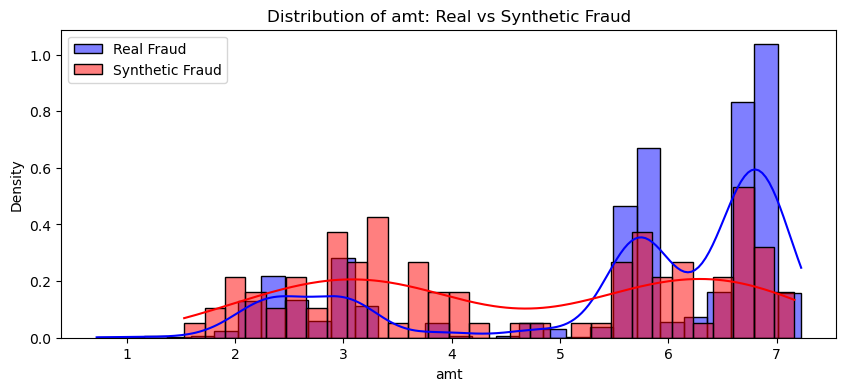

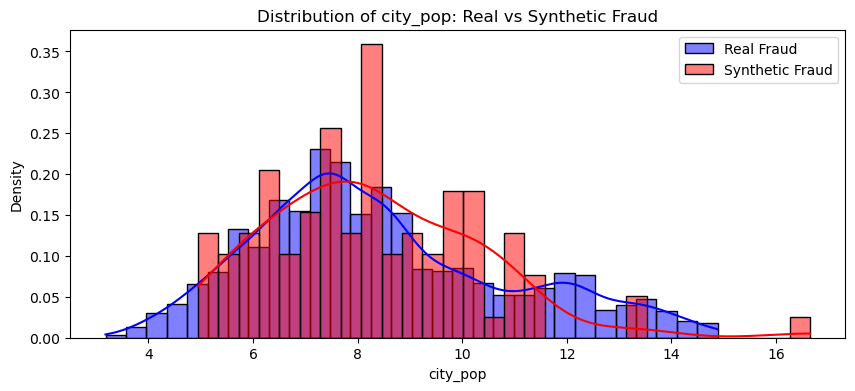

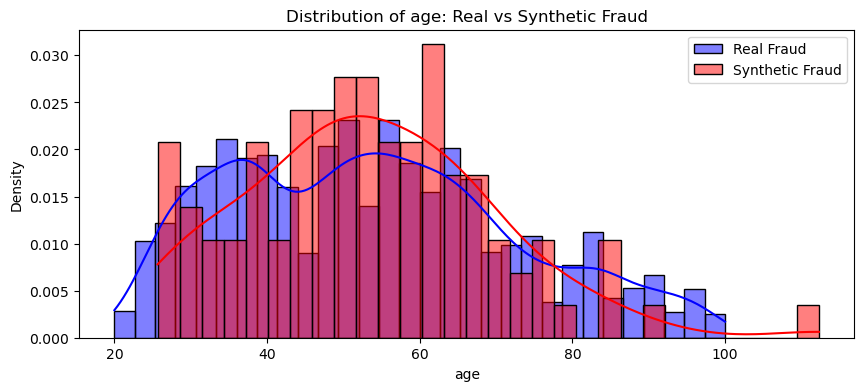

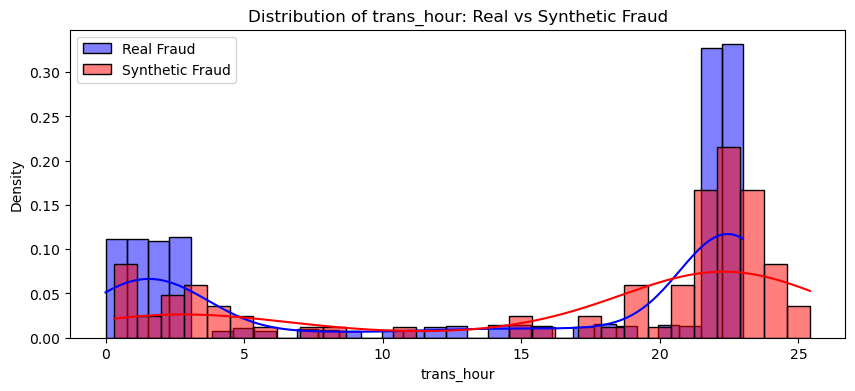

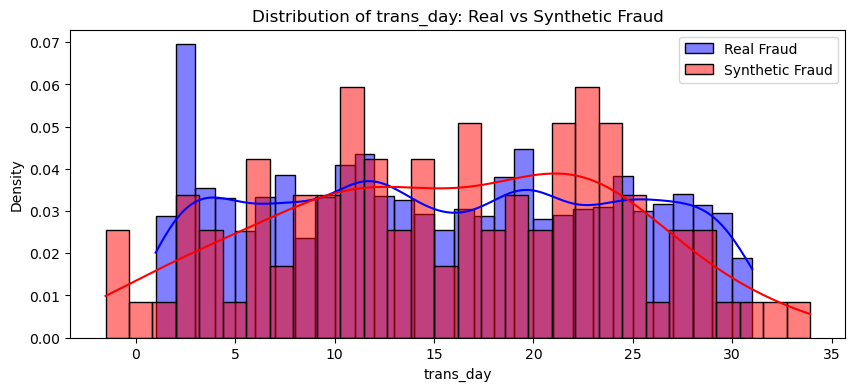

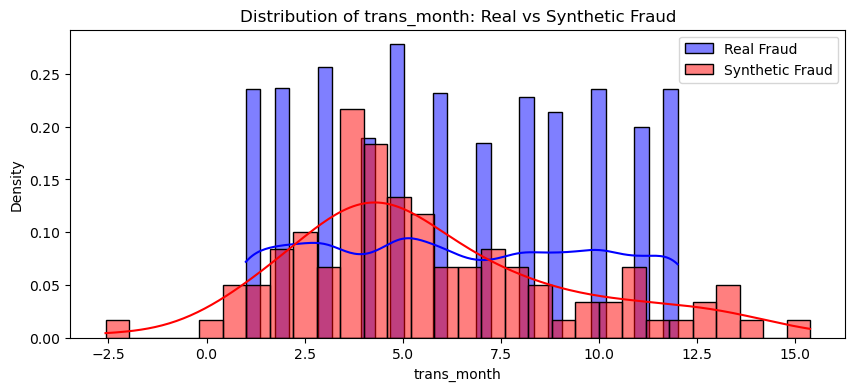

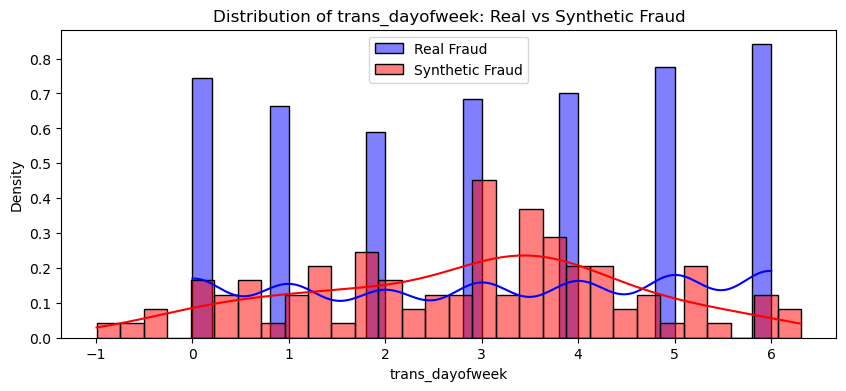

In [21]:
# Plot distributions for selected features
for col in ['amt', 'city_pop', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']:
    plt.figure(figsize=(10, 4))
    sns.histplot(real_numeric_df[col], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
    sns.histplot(synthetic_numeric_df[col], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
    plt.legend()
    plt.title(f"Distribution of {col}: Real vs Synthetic Fraud")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()